In [1]:
import tensorflow as tf
from tensorflow.keras import layers,Sequential,models
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3#RGB

In [3]:

dataset=tf.keras.preprocessing.image_dataset_from_directory(directory="PlantVillage",
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE
                                                   )
#change batch size
#change validation split or split later

#labels='inferred' -> It will automatically annote label base on sub directory name
#label mode is int to use sparse categorical crossentropy
#color mode is default rgb
#shuffle is True
# image size is 256x 256 by deafult and our dataset image size is also 256x256


Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)
#why len(dataset)=number of batches= 2152/BATCH_SIZE

68

In [6]:
2152/BATCH_SIZE

67.25

(32, 256, 256, 3)
tf.Tensor([0 2 1 0 2 0 1 1 1 1 0 1 0 0 0 1 1 0 0 0 2 0 1 1 0 0 1 0 1 1 0 0], shape=(32,), dtype=int32)


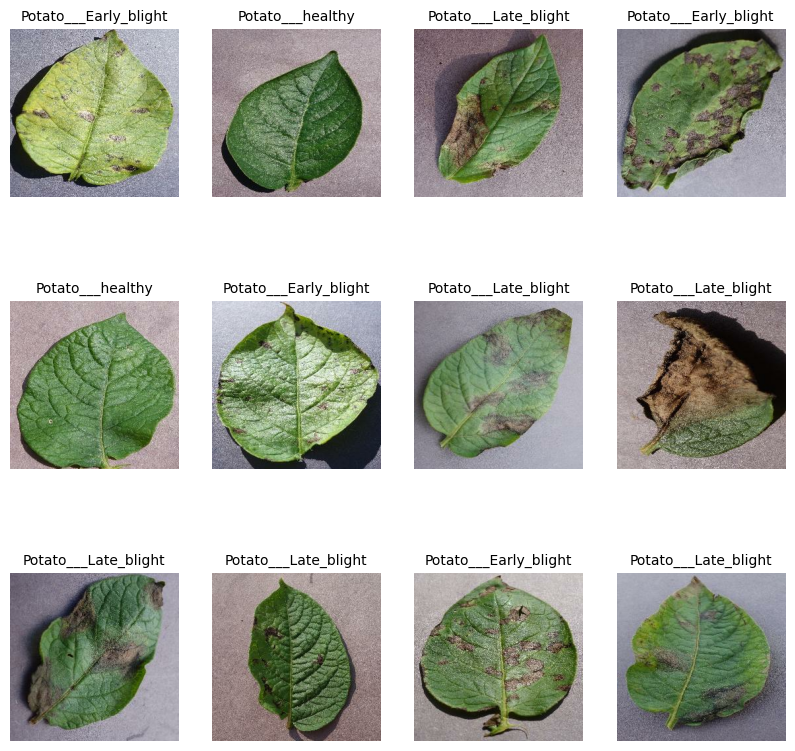

In [7]:
for image_batch,labels in dataset.take(1):
    print(image_batch.shape)
    print(labels)
    plt.figure(figsize=(10,10))
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.title(class_names[labels[i]],fontsize=10)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
    

# Train-Val-Test split

=>80% Training \
=>10% Validation \
=>10% Test

In [8]:
train_size=int(0.8*len(dataset))
val_size=int(0.1*len(dataset))
test_size=len(dataset)-train_size-val_size

print("Sizes are in number of batches")
print("Train->",train_size)
print("val->",val_size)
print("Test->",test_size)


Sizes are in number of batches
Train-> 54
val-> 6
Test-> 8


In [9]:
# train_ds=dataset.take(train_size)
# val_ds=dataset.skip(train_size).take(val_size)
# test_ds=dataset.skip(train_size+val_size)

In [10]:
def get_dataset_partition(ds,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000,seed=None):
    '''
    train split=1-val_split-test_split
    here by default
    train_split=0.8
    val_split=0.1
    test_split=0.1
    '''
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed)
    ds_size=len(ds)
    
    train_split=1-val_split-test_split
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size+val_size)
    
    
    return train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds=get_dataset_partition(dataset)

In [12]:
len(train_ds)

54

In [13]:
len(val_ds)

6

In [14]:
len(test_ds)

8

# PIPELINE

In [1]:
#with cache and prefetch
SHUFFLE_SIZE=1000# buffer size

### WARNING: If you are caching to file, delete cache file if you are doing transformation before model.predict OR Your dataset got change(update)
## First do transformation then cache
#### OR Cache to memory if you have enough memory

#### WHY??? because after first epoch it will use cache data and even if you retrain your model later it will use cache data(means it will use cache data for every run if you cache to file)

In [16]:
#cache in file
# train_ds=train_ds.cache(filename="cache/train_ds_cache").shuffle(SHUFFLE_SIZE).prefetch(
#     buffer_size=tf.data.AUTOTUNE)
# val_ds=val_ds.cache(filename="cache/val_ds_cache").shuffle(SHUFFLE_SIZE).prefetch(
#     buffer_size=tf.data.AUTOTUNE)
# test_ds=test_ds.cache(filename="cache/test_ds_cache").shuffle(SHUFFLE_SIZE).prefetch(
#     buffer_size=tf.data.AUTOTUNE)

In [17]:
train_ds=train_ds.cache().shuffle(SHUFFLE_SIZE).prefetch(
    buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(SHUFFLE_SIZE).prefetch(
    buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(SHUFFLE_SIZE).prefetch(
    buffer_size=tf.data.AUTOTUNE)

In [18]:
IMAGE_SIZE

256

#### resize and rescale

In [19]:

# our data is already 256x256 . then why we need?. 
#This resize layer is for new data during prediction
resize_and_rescale=Sequential([
    layers.Resizing(height=IMAGE_SIZE,width=IMAGE_SIZE),#256 x 256
    layers.Rescaling(1.0/255)  
    
])

#### Data Augmentation

In [20]:
data_augmentation=Sequential([
    layers.RandomFlip(mode='horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.1))
    # I choose randomly
])

#### interleave(num_parallel_calls) use for data coming from different dataset

## Model

In [21]:
INPUT_SHAPE=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=INPUT_SHAPE),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)), 
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
    
])

model.build(input_shape=INPUT_SHAPE)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 32)         

In [23]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [25]:
EPOCHS=30

In [26]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    
)

Epoch 1/30
54/54 [==============================] - 15s 166ms/step - loss: 0.9221 - accuracy: 0.4769 - val_loss: 0.8697 - val_accuracy: 0.4375
Epoch 2/30
54/54 [==============================] - 6s 109ms/step - loss: 0.8811 - accuracy: 0.5943 - val_loss: 0.7764 - val_accuracy: 0.7031
Epoch 3/30
54/54 [==============================] - 5s 101ms/step - loss: 0.6403 - accuracy: 0.7419 - val_loss: 0.3801 - val_accuracy: 0.8333
Epoch 4/30
54/54 [==============================] - 5s 101ms/step - loss: 0.3659 - accuracy: 0.8553 - val_loss: 0.5520 - val_accuracy: 0.7760
Epoch 5/30
54/54 [==============================] - 5s 100ms/step - loss: 0.3150 - accuracy: 0.8773 - val_loss: 0.3388 - val_accuracy: 0.8594
Epoch 6/30
54/54 [==============================] - 5s 99ms/step - loss: 0.2596 - accuracy: 0.8970 - val_loss: 0.1782 - val_accuracy: 0.9323
Epoch 7/30
54/54 [==============================] - 5s 100ms/step - loss: 0.1759 - accuracy: 0.9311 - val_loss: 0.1446 - val_accuracy: 0.9323
Epoch 

In [28]:
import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model_version=2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [29]:
model.save('../models/my_model_v2.h5')

In [30]:
model.evaluate(test_ds)

8/8 [==============================] - 3s 31ms/step - loss: 0.0327 - accuracy: 0.9922


[0.03271723911166191, 0.9921875]